## Complete Tiling and Decision Boundary [Part 1]

- Ok, simple goal here
- For my widest and deepest models [let's say 1024 and 32x32x32x32 for now], I need to be able to compute all my surfaces, tilings, and final decision boundary all the way through with no gaps or issues.
- The code to make this work seems non-trivial -> i'm getting close in manim but am getting gaps with the big model
- Shifting to here for now to make this work
- The viz I develop here can also be used for my preliminary training animations

In [1]:
from manimlib import *
from functools import partial
import sys, cv2 

sys.path.append('../_2025/backprop_3') #Point to folder where plane_folding_utils.py is
sys.path.append('../')
from geometric_dl_utils import *
from geometric_dl_utils_simplified import *
from polytope_intersection_utils import intersect_polytopes
import matplotlib.pyplot as plt

import matplotlib.patches as mp
tab20_colors_mpl = plt.cm.tab20_r.colors

In [3]:
#2x2
# model_path='../models/2_2_1.pth'
# model = BaarleNet([2,2])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.25, 0.25, 0.3, 0.3, 0.15]
# num_neurons=[2, 2, 2, 2, 2]

#3x3
# model_path='../models/3_3_1.pth'
# model = BaarleNet([3,3])
# model.load_state_dict(torch.load(model_path))
# viz_scales=[0.1, 0.1, 0.05, 0.05, 0.15]
# num_neurons=[3, 3, 3, 3, 2]


### 16 16 16
# model_path='../models/16_16_16_1.pth'
# model = BaarleNet([16, 16, 16])
# model.load_state_dict(torch.load(model_path))
# num_neurons=[16, 16, 16, 16, 16, 16, 2]        

### 32 32 32 32
model_path='../models/32_32_32_32_1.pth'
model = BaarleNet([32, 32, 32, 32])
model.load_state_dict(torch.load(model_path))
num_neurons=[32, 32, 32, 32, 32, 32, 32, 32, 2]        

In [4]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

def viz_descision_boundary(model, res=256, figsize=(6,6)):
    plt.clf()
    fig=plt.figure(0,figsize)
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    with torch.no_grad():
        probe_logits=model(torch.tensor(probe).float())
        probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
        probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray', extent=[-1, 1, -1, 1])
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[-1, 1, -1, 1],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')
    return ax

In [5]:
def viz_polygon_list(ax, polygon_list, alpha=0.5):
    for j, p in enumerate(polygon_list):    
        if len(p)<3: continue
        poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                        edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=alpha)
        ax.add_patch(poly)
    plt.xlim([-1,1]); plt.ylim([-1,1]); ax.axis('off')

def viz_layer_polygons(polygon_list, fig_size=(6,6)):
    '''Assume triple layer list for now'''
    plt.clf()
    fig=plt.figure(0, fig_size)
    sqr=int(np.ceil(np.sqrt(len(polygon_list))))
    for i, pss in enumerate(polygon_list):
        ax=fig.add_subplot(sqr,sqr,i+1)
        for ps in pss: 
            viz_polygon_list(ax, ps)

- Ok I've decided it's fully worth decoupling stuff and if it's still sow running a caching step - let's go!
- Really important thing here is that the polygon is going to be kinda the core building block
- Let me start with some nice psuedo code.
- Hmm how do I do the cool different lines for each layer thing? One problem at a time I guess. Do want that to be an option though!
- Ok, now I'm really not sure when it makes sense to merge zero regions -> or how much I need to worry about this really
- I guess let me keep moving and then come back to it -> I think my schema will allow for it without huge problems.
- Ok big decision boundary is working, now I think I know how I want to handle merging zero regions, then I can look at top polytopes.
- Although my gut says it's time to write -> yeah ok let me add my strategy here to my hacking list and go write -> i think that make sense -> it will be harder to write later - it's almost 3. 

In [6]:
# use this data structure all the way through, might just need a little 
# deviation at the end. 
# The output of each layer will be a list of list of 3d polygons as Nx3 numpy arrays. The outer list correspond to the 
# number of nuerons in that layer, and the inner list correspond to the polygons output by each neuron
# The xy values of each polygon are the same across all neurons
polygons={} #dict of all polygones as we go. 
polygons['input_plane']=[np.array([[-1., -1, 0], 
                                    [-1, 1, 0], 
                                    [1, 1, 0], 
                                    [1, -1, 0]])]


#Ok at some poing in these needs loops I think I need to merge zero regions? Is that really just for viz though? Might need to think about that. 
polygons['0.linear_out']=process_with_layers(model.model[0], polygons['input_plane']) #Just first layer of model
polygons['0.split_polygons_nested']=split_polygons_with_relu_simple(polygons['0.linear_out']) #Triple nested list so we can simplify merging process layer. 
polygons['0.new_tiling']=recompute_tiling(polygons['0.split_polygons_nested'])
polygons['0.new_tiling_unraveled']=[item for sublist in polygons['0.new_tiling'] for item in sublist]

#Ok so I think now we repeat
polygons['1.linear_out']=process_with_layers(model.model[:3], polygons['0.new_tiling_unraveled'])
polygons['1.split_polygons_nested']=split_polygons_with_relu_simple(polygons['1.linear_out'])
polygons['1.new_tiling']=recompute_tiling(polygons['1.split_polygons_nested'])
polygons['1.new_tiling_unraveled']=[item for sublist in polygons['1.new_tiling'] for item in sublist]

polygons['2.linear_out']=process_with_layers(model.model[:5], polygons['1.new_tiling_unraveled'])
polygons['2.split_polygons_nested']=split_polygons_with_relu_simple(polygons['2.linear_out'])
polygons['2.new_tiling']=recompute_tiling(polygons['2.split_polygons_nested'])
polygons['2.new_tiling_unraveled']=[item for sublist in polygons['2.new_tiling'] for item in sublist]

polygons['3.linear_out']=process_with_layers(model.model[:7], polygons['2.new_tiling_unraveled'])
polygons['3.split_polygons_nested']=split_polygons_with_relu_simple(polygons['3.linear_out'])
polygons['3.new_tiling']=recompute_tiling(polygons['3.split_polygons_nested'])
polygons['3.new_tiling_unraveled']=[item for sublist in polygons['3.new_tiling'] for item in sublist]

# Ok let me get to the end here (decision boundary on top of heatmap, and then I'll go back and think about 
# when/where/how to merge zere regions, and how to capture/viz the nested nature of this stuff! 
# I think like previous layers become lines basically
polygons['4.linear_out']=process_with_layers(model.model, polygons['3.new_tiling_unraveled'])

intersection_lines, new_2d_tiling, upper_polytope, indicator = intersect_polytopes(*polygons['4.linear_out'])

<Figure size 640x480 with 0 Axes>

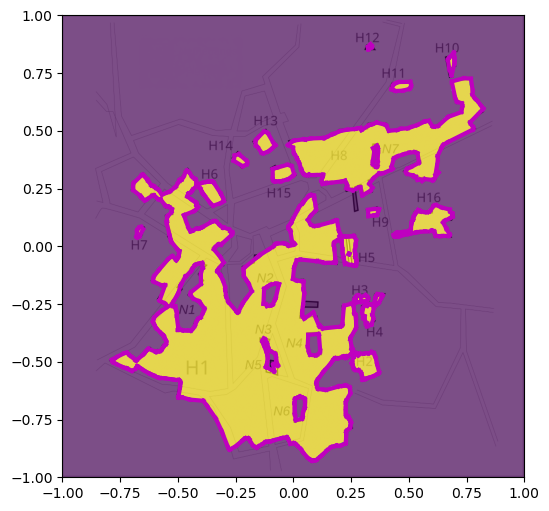

In [7]:
ax=viz_descision_boundary(model)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], c='m', linewidth=3)

Fuck yeah its so cool that that actually works lol. 

<Figure size 640x480 with 0 Axes>

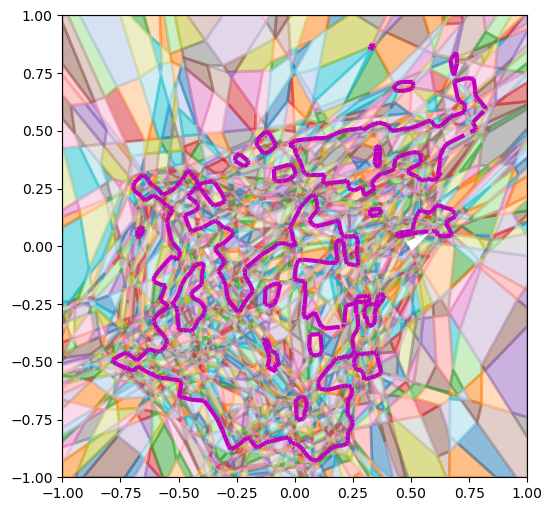

In [8]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, p in enumerate(new_2d_tiling):    
    if len(p)<3: continue
    poly=mp.Polygon(p[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], 
                    edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.5)
    ax.add_patch(poly)
for l in intersection_lines:
    ax.plot(l[:,0], l[:,1], 'm--', linewidth=3, )
plt.xlim([-1,1]); plt.ylim([-1,1]);

Ok making progress here, next: 
- Can we scale up and shit still work?
   - Ok 16 16 16 is working - nice! This was a big hold up in manim
   - Also doesn't feel slow at this point -> that's a good sign.
   - FUCK YES -> 32 32 32 32 works and looks DOPE. This was the first thing I've hacked on in a while where the AI really want not figuring it out -> interesting. 
- Do i have a reliable way to fine top polytope?
- What about zero regions?

<Figure size 640x480 with 0 Axes>

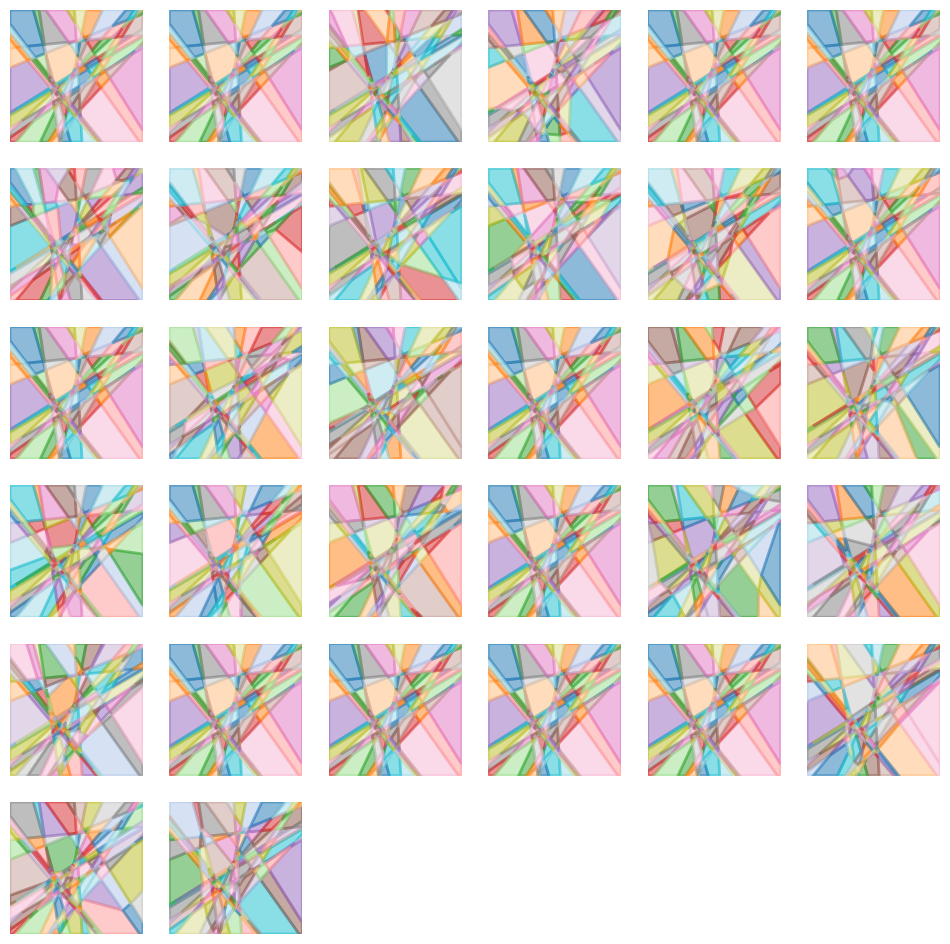

In [12]:
plt.clf()
fig=plt.figure(0, (12,12))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(6,6,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)

---

In [80]:
polygons['2.linear_out'][0]

[array([[ 1.        ,  0.88613825,  6.99180889],
        [ 0.7011857 ,  0.57777329,  4.73641014],
        [-0.53432414,  0.21162757,  3.90693188],
        [-0.73975797,  1.        , 11.70784283],
        [ 1.        ,  1.        ,  8.05618858]]),
 array([[ 0.7011857 ,  0.57777329,  4.73641014],
        [-0.3476844 , -0.50462065, -0.43245053],
        [-0.53432414,  0.21162757,  3.90693116]]),
 array([[ 0.7011857 ,  0.57777329,  4.73641014],
        [ 1.        ,  0.88613825,  6.99180889],
        [ 1.        , -1.        ,  5.94834042],
        [ 0.56731292, -1.        ,  2.92950749],
        [-0.00750008, -0.85291479, -0.9995563 ]]),
 array([[-0.00750008, -0.85291479, -0.9995563 ],
        [ 0.56731292, -1.        ,  2.92950749],
        [-0.08035816, -1.        ,  2.39475679]]),
 array([[ 0.7011857 ,  0.57777329,  4.73641014],
        [-0.00750008, -0.85291479, -0.9995563 ],
        [-0.27474543, -0.7845311 , -1.21243596],
        [-0.3476844 , -0.50462065, -0.43245053]]),
 array([[-

In [77]:
for oo in polygons['2.linear_out']:
    print(len(oo))
    # for o in oo:
    #     print(len(o))

21
21


In [73]:
model.model

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): ReLU()
  (4): Linear(in_features=3, out_features=2, bias=True)
)

In [57]:
len(polygons['1.split_polygons_nested'])

3

<Figure size 640x480 with 0 Axes>

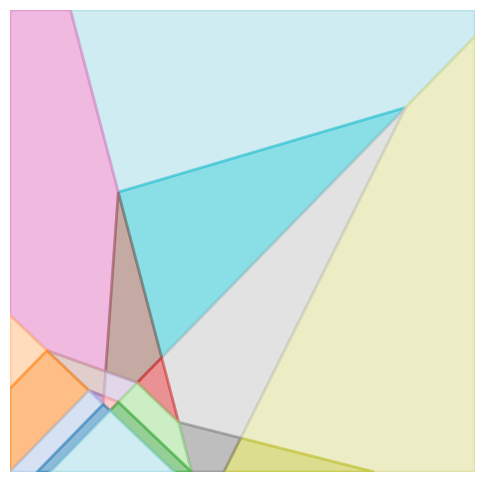

In [72]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
viz_polygon_list(ax, polygons['1.new_tiling_unraveled'])

<Figure size 640x480 with 0 Axes>

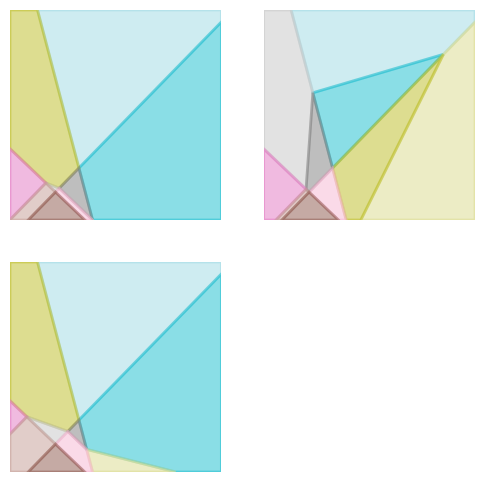

In [70]:
plt.clf()
fig=plt.figure(0, (6,6))
for i, polygons_by_neuron in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(2,2,i+1)
    unravelled=[item for sublist in polygons_by_neuron for item in sublist]
    viz_polygon_list(ax, unravelled)

<Figure size 640x480 with 0 Axes>

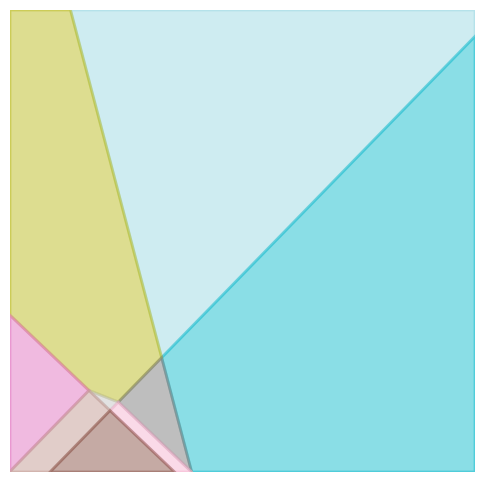

In [68]:
unravelled

[array([[ 1.        ,  0.88613825, 18.78158188],
        [-0.3476844 , -0.50462065,  4.07755852],
        [-0.73975797,  1.        , 24.71588898],
        [ 1.        ,  1.        , 20.26751328]]),
 array([[ 1.        , -1.        ,  2.31330132],
        [-0.21733431, -1.        ,  0.        ],
        [-0.21867463, -0.99970829,  0.        ],
        [-0.3476844 , -0.50462065,  4.07755852],
        [ 1.        ,  0.88613825, 18.78158188]]),
 array([[-0.21733431, -1.        ,  0.        ],
        [-0.21859861, -1.        , -0.00240254],
        [-0.21867463, -0.99970829,  0.        ]]),
 array([[-0.73975797,  1.        , 24.71588898],
        [-0.3476844 , -0.50462065,  4.07755852],
        [-0.5341746 , -0.69707143,  0.        ],
        [-0.66049404, -0.64690777,  0.        ],
        [-1.        , -0.32124362,  2.91983438],
        [-1.        ,  1.        , 23.13469696]]),
 array([[-0.5341746 , -0.69707143,  0.        ],
        [-0.5698345 , -0.73387108, -0.7796942 ],
        [-0.

[[array([[ 1.        ,  0.88613825, 18.78158188],
       [-0.3476844 , -0.50462065,  4.07755852],
       [-0.73975797,  1.        , 24.71588898],
       [ 1.        ,  1.        , 20.26751328]])], [array([[ 1.        , -1.        ,  2.31330132],
       [-0.21733431, -1.        ,  0.        ],
       [-0.21867463, -0.99970829,  0.        ],
       [-0.3476844 , -0.50462065,  4.07755852],
       [ 1.        ,  0.88613825, 18.78158188]]), array([[-0.21733431, -1.        ,  0.        ],
       [-0.21859861, -1.        , -0.00240254],
       [-0.21867463, -0.99970829,  0.        ]])], [array([[-0.73975797,  1.        , 24.71588898],
       [-0.3476844 , -0.50462065,  4.07755852],
       [-0.5341746 , -0.69707143,  0.        ],
       [-0.66049404, -0.64690777,  0.        ],
       [-1.        , -0.32124362,  2.91983438],
       [-1.        ,  1.        , 23.13469696]]), array([[-0.5341746 , -0.69707143,  0.        ],
       [-0.5698345 , -0.73387108, -0.7796942 ],
       [-0.66049404, -0.64

<Figure size 640x480 with 0 Axes>

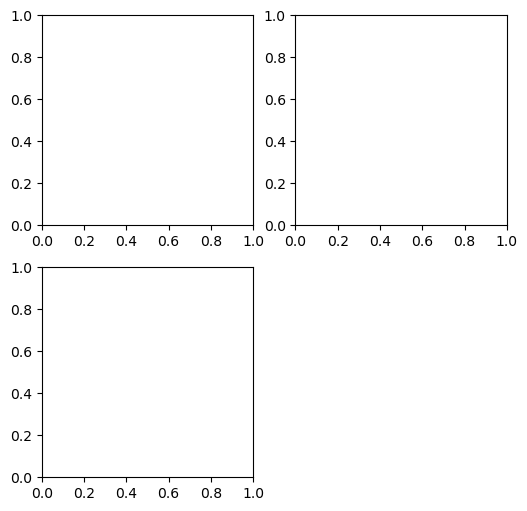

In [59]:
plt.clf()
fig=plt.figure(0, (6,6))
for i, pss in enumerate(polygons['1.split_polygons_nested']):
    ax=fig.add_subplot(2,2,i+1)
    print(pss)

<Figure size 640x480 with 0 Axes>

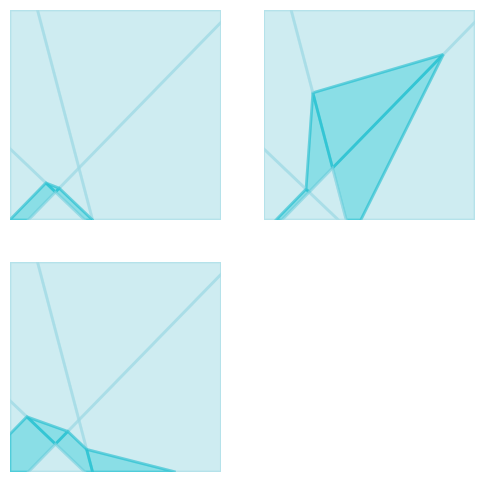

In [53]:
viz_layer_polygons(polygons['1.split_polygons_nested']) #Assuming triple nesting here 

<Figure size 640x480 with 0 Axes>

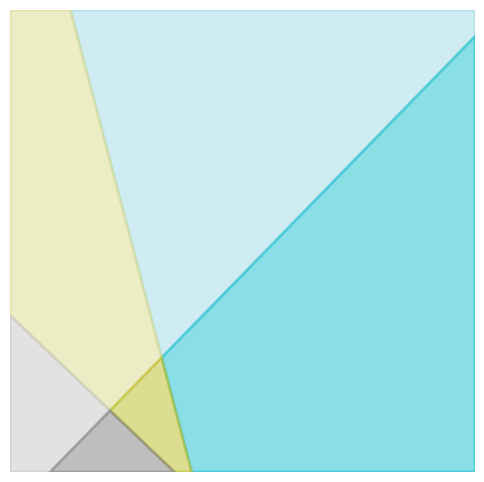

In [54]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
viz_polygon_list(ax, polygons['0.new_tiling_unraveled'])

<Figure size 640x480 with 0 Axes>

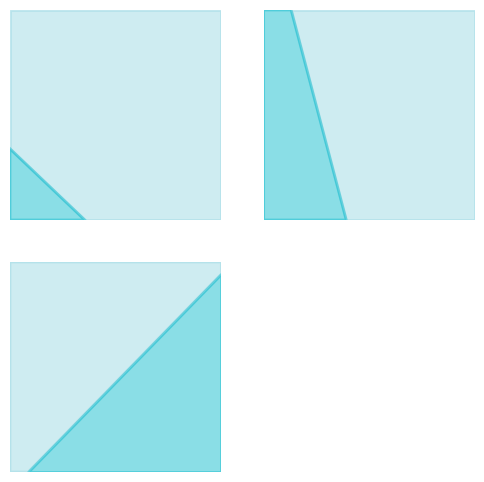

In [41]:
viz_layer_polygons(polygons['0.split_polygons_nested']) #Assuming triple nesting here 

<Figure size 640x480 with 0 Axes>

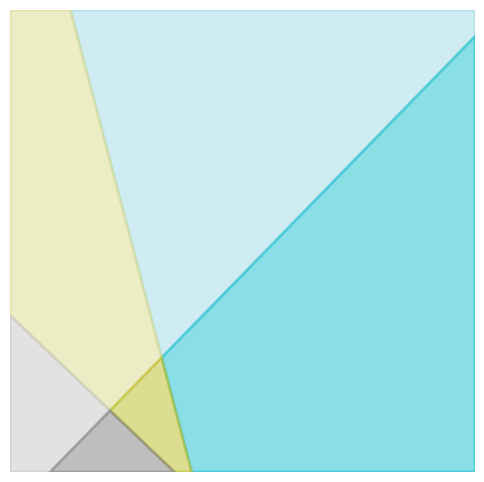

In [45]:
plt.clf()
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
viz_polygon_list(ax, polygons['0.new_tiling_unraveled'])

In [29]:
polygons[-1][0]

[array([[ 1.        ,  0.88613825,  0.        ],
        [-0.3476844 , -0.50462065,  0.        ],
        [-0.73975797,  1.        ,  0.        ],
        [ 1.        ,  1.        ,  0.        ]]),
 array([[ 1.        , -1.        ,  0.        ],
        [-0.21859861, -1.        ,  0.        ],
        [-0.3476844 , -0.50462065,  0.        ],
        [ 1.        ,  0.88613825,  0.        ]]),
 array([[-0.73975797,  1.        ,  0.        ],
        [-0.3476844 , -0.50462065,  0.        ],
        [-0.5698345 , -0.73387108,  0.        ],
        [-1.        , -0.32124362,  0.        ],
        [-1.        ,  1.        ,  0.        ]]),
 array([[-0.21859861, -1.        ,  0.        ],
        [-0.29239423, -1.        ,  0.        ],
        [-0.5698345 , -0.73387108,  0.        ],
        [-0.3476844 , -0.50462065,  0.        ]]),
 array([[-0.5698345 , -0.73387108,  0.        ],
        [-0.82772089, -1.        ,  0.        ],
        [-1.        , -1.        ,  0.        ],
        [-1.

In [ ]:
def recompute_tiling(polygons_nested):
    '''
    polygons_nested is a list of list of list of polygons in 3d space as Nx3 or Nx2 numpy arrays 
    this method only uses the first 2 dimensions
    The outer list correspond to neurons in a given layer, recompute_tiling collapses across this dimension
    The second layer of list correspond to "input polygons" into the layer that maybe have been split by the given layer's Relu
    The inner layer correspond to resulting polygons from splitting a polygon that was input into this layer
    #The length of the second layer lists shoudl all the same
    recompute_tiling iterates through input polygons (second layer list). 
    For each input polygon, recompute_tiling collapses this polygon across all neurons by finding the intersections of all new polygons
    generate withing this input polygon. In the null case, all polygons for a specific neuron will be lists of length 1, where the polygon 
    has not been split by any of the neurons - in this case recompute_tiling just returns the original polygon borders
    If only one neuron has split the polygon at hand, then polygons_nested can just return these 2 new polygons
    Otherwise recompute_tiling needs to recompute N new polygons based on the intersections of the new polygons formed by mutiple neurons
    recompute_tiling returns a list of list of polygons, where the outer list correspond to the number of input polygons (should match the length
    of the second nested list passed in), and the inner lists are all the polygons that an input polygon are split into. 
    '''
    

In [6]:
polygons[-2]

[[array([[-1.        , -1.        , -2.15233326],
         [-1.        ,  1.        ,  4.18965721],
         [ 1.        ,  1.        , 10.27308178],
         [ 1.        , -1.        ,  3.93109155]])],
 [array([[-1.        , -1.        , -4.18908358],
         [-1.        ,  1.        , -1.39515448],
         [ 1.        ,  1.        ,  9.32682228],
         [ 1.        , -1.        ,  6.5328927 ]])],
 [array([[-1.        , -1.        ,  0.4431847 ],
         [-1.        ,  1.        ,  5.42879725],
         [ 1.        ,  1.        ,  0.28383526],
         [ 1.        , -1.        , -4.70177698]])]]

<Figure size 640x480 with 0 Axes>

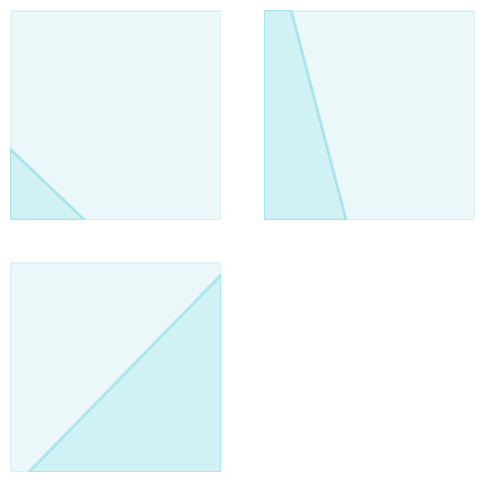

In [11]:
viz_layer_polygons(polygons[-1])

- I can't tell yet how important the merging zero regions thing is -> I think I do want it visually -> I think that's important
- I can definitely do it separately!
- Hmm do I want to kinda keep the overall structure during spliting so I can merge/combine splits on a per polygon basis?
- I bet that would save compute - don't want to overengineer her obviously, but that feels like a potentially pretty powerful simplification...
- If I do that then I actually need a triple nested list I think?
- Maybe that's fine -> there's probably some more clever data structure here -> but I guess that's fine?
- And in the merge step we go to a double listed structure again?

In [12]:
polygons[-2]

[[array([[-1.        , -1.        , -2.15233326],
         [-1.        ,  1.        ,  4.18965721],
         [ 1.        ,  1.        , 10.27308178],
         [ 1.        , -1.        ,  3.93109155]])],
 [array([[-1.        , -1.        , -4.18908358],
         [-1.        ,  1.        , -1.39515448],
         [ 1.        ,  1.        ,  9.32682228],
         [ 1.        , -1.        ,  6.5328927 ]])],
 [array([[-1.        , -1.        ,  0.4431847 ],
         [-1.        ,  1.        ,  5.42879725],
         [ 1.        ,  1.        ,  0.28383526],
         [ 1.        , -1.        , -4.70177698]])]]

In [13]:
polygons[-1]

[[array([[-1.        , -0.32124362,  0.        ],
         [-1.        ,  1.        ,  4.18965721],
         [ 1.        ,  1.        , 10.27308178],
         [ 1.        , -1.        ,  3.93109155],
         [-0.29239423, -1.        ,  0.        ]]),
  array([[-1.        , -1.        , -2.15233326],
         [-1.        , -0.32124362,  0.        ],
         [-0.29239423, -1.        ,  0.        ]])],
 [array([[-0.73975797,  1.        ,  0.        ],
         [ 1.        ,  1.        ,  9.32682228],
         [ 1.        , -1.        ,  6.5328927 ],
         [-0.21859861, -1.        ,  0.        ]]),
  array([[-1.        , -1.        , -4.18908358],
         [-1.        ,  1.        , -1.39515448],
         [-0.73975797,  1.        ,  0.        ],
         [-0.21859861, -1.        ,  0.        ]])],
 [array([[-1.        , -1.        ,  0.4431847 ],
         [-1.        ,  1.        ,  5.42879725],
         [ 1.        ,  1.        ,  0.28383526],
         [ 1.        ,  0.88613825,  0. 

In [ ]:
def merge_split_polygons(

In [18]:
# all_polygons, merged_zero_polygons, unmerged_polygons=split_polygons_with_relu(polygons[-1])

In [14]:
polygons[-1][0]

[array([[-1.        , -1.        , -2.15233326],
        [-1.        ,  1.        ,  4.18965721],
        [ 1.        ,  1.        , 10.27308178],
        [ 1.        , -1.        ,  3.93109155]])]

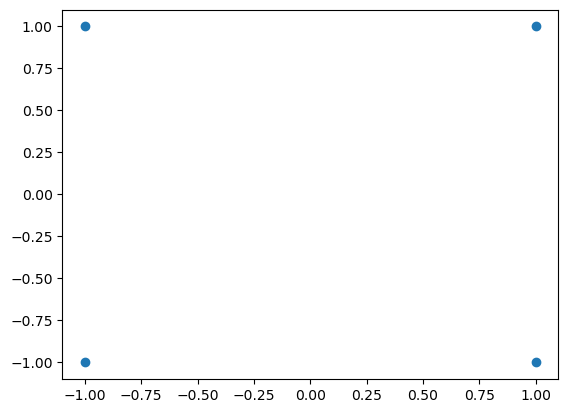

In [15]:
plt.scatter(polygons[-1][0][0][:,0], polygons[-1][0][0][:,1])

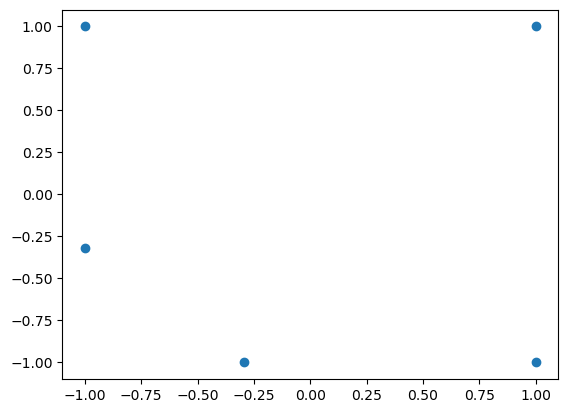

In [16]:
plt.scatter(all_polygons[0][0][:,0], all_polygons[0][0][:,1])

In [11]:
polygons

[[[array([[-1.        , -1.        , -2.15233326],
          [-1.        ,  1.        ,  4.18965721],
          [ 1.        , -1.        ,  3.93109155],
          [ 1.        ,  1.        , 10.27308178]])],
  [array([[-1.        , -1.        , -4.18908358],
          [-1.        ,  1.        , -1.39515448],
          [ 1.        , -1.        ,  6.5328927 ],
          [ 1.        ,  1.        ,  9.32682228]])],
  [array([[-1.        , -1.        ,  0.4431847 ],
          [-1.        ,  1.        ,  5.42879725],
          [ 1.        , -1.        , -4.70177698],
          [ 1.        ,  1.        ,  0.28383526]])]]]

In [13]:
all_polygons

[[array([[-1.        , -0.32124362,  0.        ],
         [-0.65355954, -0.65355954,  0.        ],
         [ 1.        , -1.        ,  3.93109155],
         [ 1.        ,  1.        , 10.27308178],
         [-1.        ,  1.        ,  4.18965721]]),
  array([[-1.        , -1.        ,  0.        ],
         [-0.65355954, -0.65355954,  0.        ],
         [-1.        , -0.32124362,  0.        ]])],
 [array([[-0.38012537, -0.38012537,  0.        ],
         [ 1.        , -1.        ,  6.5328927 ],
         [ 1.        ,  1.        ,  9.32682228],
         [-0.64804587,  0.64804587,  0.        ]]),
  array([[-1.        , -1.        ,  0.        ],
         [-0.38012537, -0.38012537,  0.        ],
         [-0.64804587,  0.64804587,  0.        ],
         [-1.        ,  1.        ,  0.        ]])],
 [array([[-1.        , -1.        ,  0.4431847 ],
         [ 0.07176496, -0.07176496,  0.        ],
         [ 1.        ,  0.88613825,  0.        ],
         [ 1.        ,  1.        ,  0.2

[[-1.0, -0.32124361603408336], [-1.0, 1.0], [1.0, 1.0], [1.0, -1.0], [-0.2923942259467913, -1.0]]
[[-1.0, -1.0], [-1.0, -0.32124361603408336], [-0.2923942259467913, -1.0]]
[[-0.7397579741536978, 1.0], [1.0, 1.0], [1.0, -1.0], [-0.21859861153891558, -1.0]]
[[-1.0, -1.0], [-1.0, 1.0], [-0.7397579741536978, 1.0], [-0.21859861153891558, -1.0]]
[[-1.0, -1.0], [-1.0, 1.0], [1.0, 1.0], [1.0, 0.8861382521534376], [-0.8277208925051651, -1.0]]
[[1.0, 0.8861382521534376], [1.0, -1.0], [-0.8277208925051651, -1.0]]


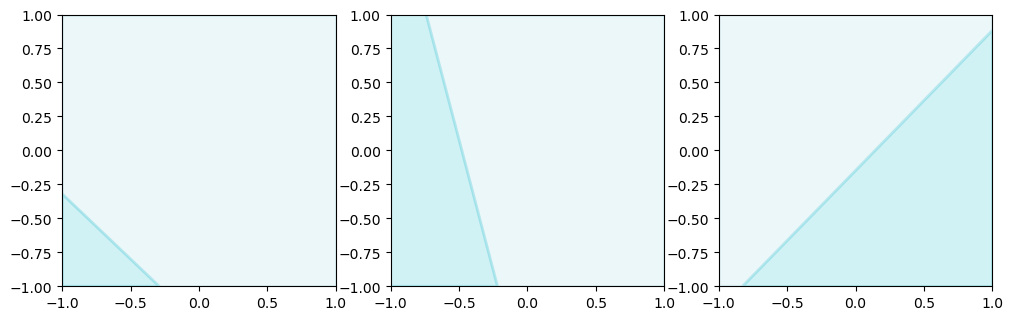

In [30]:
tab20_colors_mpl

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.74117647

In [20]:
polygons[-1]

[[array([[-1.        , -0.32124362,  0.        ],
         [-1.        ,  1.        ,  4.18965721],
         [ 1.        , -1.        ,  3.93109155],
         [ 1.        ,  1.        , 10.27308178],
         [-0.65355954, -0.65355954,  0.        ]]),
  array([[-1.        , -1.        , -2.15233326],
         [-1.        , -0.32124362,  0.        ],
         [-0.65355954, -0.65355954,  0.        ]])],
 [array([[-0.64804587,  0.64804587,  0.        ],
         [ 1.        , -1.        ,  6.5328927 ],
         [ 1.        ,  1.        ,  9.32682228],
         [-0.38012537, -0.38012537,  0.        ]]),
  array([[-1.        , -1.        , -4.18908358],
         [-1.        ,  1.        , -1.39515448],
         [-0.64804587,  0.64804587,  0.        ],
         [-0.38012537, -0.38012537,  0.        ]])],
 [array([[-1.        , -1.        ,  0.4431847 ],
         [-1.        ,  1.        ,  5.42879725],
         [ 0.07176496, -0.07176496,  0.        ],
         [ 1.        ,  0.88613825,  0. 

In [4]:
# def split_polygons_with_relu(polygons):
#     """
#     Split 3D polygons that cross the z=0 plane (ReLU boundary)
#     If a polygon does not cross z=0, simply pass through. If a polygon does cross z=0, split at the z=0 line, remove old polygon and
#     add new polygons. 
    
#     Args:
#         polygons: List of lists of numpy arrays representing 3D polygons
#                           Each sublist represents polygons for one neuron
#                           Each numpy array is a polygon with shape (n_points, 3)
    
#     Returns:
#         - split_polygons: List of lists of numpy arrays with split polygons (same format as before)
#     """

[[array([[-1.        , -1.        ,  3.76239991],
         [-1.        ,  1.        , 14.49072647],
         [ 1.        , -1.        ,  5.94834042],
         [ 1.        ,  1.        ,  8.05619335]])],
 [array([[ 1.        ,  0.07408859,  0.        ],
         [ 1.        ,  1.        ,  4.8626976 ],
         [-0.07130466, -0.07130466,  0.        ]]),
  array([[-1.        , -1.        , -4.21538782],
         [-1.        ,  1.        , -0.39306426],
         [ 1.        , -1.        , -5.64089394],
         [ 1.        ,  0.07408859,  0.        ],
         [-0.07130466, -0.07130466,  0.        ]])]]

In [ ]:
split_with_relu(polygons[-1])

In [29]:
polygons

[[[array([[-1.        , -1.        ,  3.76239991],
          [-1.        ,  1.        , 14.49072647],
          [ 1.        , -1.        ,  5.94834042],
          [ 1.        ,  1.        ,  8.05619335]])],
  [array([[-1.        , -1.        , -4.21538782],
          [-1.        ,  1.        , -0.39306426],
          [ 1.        , -1.        , -5.64089394],
          [ 1.        ,  1.        ,  4.8626976 ]])]]]

In [27]:
polygons_out

[[array([[-1.        , -1.        ,  3.76239991],
         [-1.        ,  1.        , 14.49072647],
         [ 1.        , -1.        ,  5.94834042],
         [ 1.        ,  1.        ,  8.05619335]])],
 [array([[-1.        , -1.        , -4.21538782],
         [-1.        ,  1.        , -0.39306426],
         [ 1.        , -1.        , -5.64089394],
         [ 1.        ,  1.        ,  4.8626976 ]])]]

In [20]:
polygons

[array([[-1., -1.,  0.],
        [-1.,  1.,  0.],
        [ 1., -1.,  0.],
        [ 1.,  1.,  0.]])]

In [12]:
model.model[:3]

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
)

In [ ]:
def process_with_layers(model_layers, polygons_flat):
    '''
    model_layers is a pytorch Sequential object, in practice is typically a subset of a model, or could be full model. 
    polygons_flat is a list of 3d or 2d polygons as Nx3 or Nx2 numpy arrays.
    In the Nx3 case, process_with_linear_layer only uses first xy coords, not the z value
    Returns a new list of list of polygons. Outer dimension is over neurons, inner list is over polygons as Nx3 numpy arrays
    The xy values of each polygon are the same across all neurons
    The z value of each point corresponds to the output of that neuron for that vertex
    '''
    for i, p in enumerate(polygons):
        with torch.no_grad():
            out=model_layers(torch.tensor(p[:,:2]).float()) #Returns num_verticesxnum_neurons 


In [22]:
with torch.no_grad():
    out=model.model[:3](torch.tensor(polygons[0][:,:2]).float())

In [23]:
out

tensor([[-1.1813e-02,  9.3177e-01, -1.5639e+00],
        [ 2.3135e+01,  7.5408e+00,  2.0341e+01],
        [ 2.3133e+00,  7.2261e+00,  8.9295e-01],
        [ 2.0268e+01,  1.4831e+00,  1.7515e+01]])

---

In [50]:
graphics_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/graphics/' #Point to folder where map images are
heatmaps_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/backprop_3/hackin/heatmaps'

Trying to decide if I want to decouple my viz pipelines from computational piplines -> not sure yet!

In [51]:
vertical_spacing=1.5
horizontal_spacing=3
colors = [BLUE, RED, GREEN, YELLOW, PURPLE, ORANGE, PINK, TEAL]

# Hmm ok I think I need to compute a different viz scale for each surface probably 
# I don't want to totally normalize the heights though, ya know?
# Maybe there's a discrete set of possible viz scales: 
adaptive_viz_scales = compute_adaptive_viz_scales(model, max_surface_height=1.0, extent=1)
#For the interesection to make sense, these scales need to match - either need to manual overide or chnage method above
final_layer_viz=scale=2*min(adaptive_viz_scales[-1]) #little manual ramp here
adaptive_viz_scales[-1]=[final_layer_viz, final_layer_viz]


surfaces=[]
surface_funcs=[]
surface_funcs_no_viz_scale=[]
for layer_idx in range(len(model.model)):
    s=Group()
    surface_funcs.append([])
    surface_funcs_no_viz_scale.append([])
    for neuron_idx in range(num_neurons[layer_idx]):
        surface_func=partial(surface_func_from_model, model=model, layer_idx=layer_idx, neuron_idx=neuron_idx, viz_scale=adaptive_viz_scales[layer_idx][neuron_idx])
        surface_func_no_scaling=partial(surface_func_from_model, model=model, layer_idx=layer_idx, neuron_idx=neuron_idx, viz_scale=1.0) #adaptive_viz_scales[layer_idx][neuron_idx])
        bent_surface = ParametricSurface(surface_func, u_range=[-1, 1], v_range=[-1, 1], resolution=(64, 64))
        ts=TexturedSurface(bent_surface, graphics_dir+'/baarle_hertog_maps/baarle_hertog_maps-11.png')
        ts.set_shading(0,0,0).set_opacity(0.75)
        s.add(ts)
        surface_funcs[-1].append(surface_func)
        surface_funcs_no_viz_scale[-1].append(surface_func_no_scaling)
    surfaces.append(s)


In [52]:
layer_idx=1
layer_1_polygons=get_polygon_corners_layer_1(model)
layer_1_polygons_3d=get_3d_polygons_layer_1(layer_1_polygons, surface_funcs_no_viz_scale, num_neurons=num_neurons[layer_idx], layer_idx=1)

In [54]:
from matplotlib.patches import Polygon
tab20_colors_mpl = plt.cm.tab20.colors

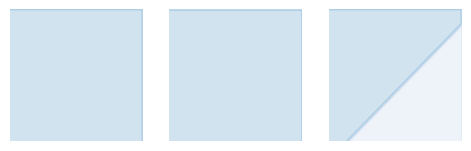

In [55]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(layer_1_polygons_3d):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        if len(polygon)<3: continue
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

In [57]:
polygon[:,:2].tolist()

[[-0.8277208974948208, -1.0], [1.0, -1.0], [1.0, 0.8861382555565747]]

Sweet - now we tile these together!

In [71]:
layer_2_polygons=carve_plane_with_relu_joints([o['relu_line'] for o in layer_1_polygons])

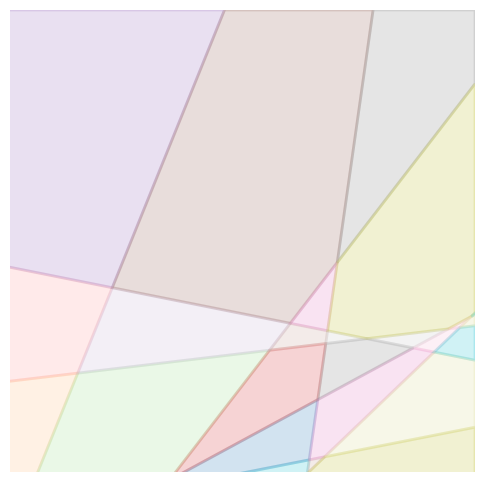

In [72]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer_2_polygons):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
    ax.add_patch(poly)
    plt.axis('off')

In [73]:
layer_idx=2
layer_2_polygons_3d=get_3d_polygons(layer_2_polygons, num_neurons[layer_idx], surface_funcs_no_viz_scale, layer_idx)

layer_idx=3
all_polygons, merged_zero_polygons, unmerged_polygons = split_polygons_with_relu(layer_2_polygons_3d)
all_polygons_after_merging=copy.deepcopy(merged_zero_polygons)
for i, o in enumerate(unmerged_polygons):
    all_polygons_after_merging[i].extend(o)

all_polygons_after_merging_2d=[]
for p in all_polygons_after_merging:
    pd2=[o[:,:2] for o in p]
    all_polygons_after_merging_2d.append(pd2)

layer3_regions_2d = find_polygon_intersections(all_polygons_after_merging_2d)

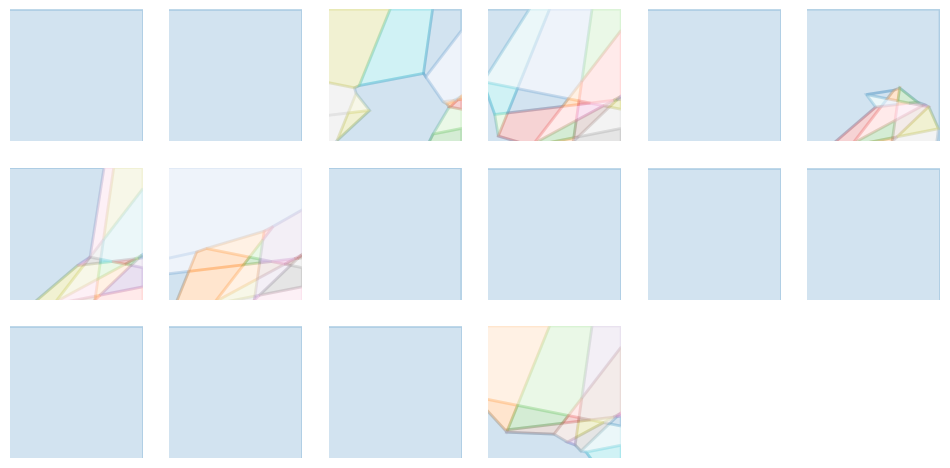

In [74]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(all_polygons_after_merging):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

In [53]:
# layer_2_polygons_3d
# all_polygons

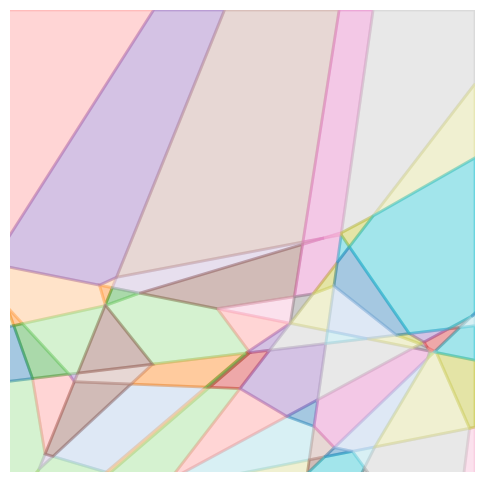

In [75]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer3_regions_2d):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.4)
    ax.add_patch(poly)
    plt.axis('off')

In [79]:
layer_idx=4
layer_2_polygons_3d=get_3d_polygons(layer3_regions_2d, num_neurons[layer_idx], surface_funcs_no_viz_scale, layer_idx)

layer_idx=5
all_polygons, merged_zero_polygons, unmerged_polygons = split_polygons_with_relu(layer_2_polygons_3d)
all_polygons_after_merging=copy.deepcopy(merged_zero_polygons)
for i, o in enumerate(unmerged_polygons):
    all_polygons_after_merging[i].extend(o)

all_polygons_after_merging_2d=[]
for p in all_polygons_after_merging:
    pd2=[o[:,:2] for o in p]
    all_polygons_after_merging_2d.append(pd2)

layer3_regions_2d = find_polygon_intersections(all_polygons_after_merging_2d)

GEOSException: TopologyException: side location conflict at -0.22400776166370656 0.20207297350544803. This can occur if the input geometry is invalid.

In [ ]:
fig=plt.figure(0, (12,12))
for i, polygons in enumerate(all_polygons_after_merging):
    ax=fig.add_subplot(6,6,i+1)
    for j, polygon in enumerate(polygons):
        poly=Polygon(polygon[:,:2].tolist(), facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.2)
        ax.add_patch(poly)
        plt.axis('off')

In [ ]:
fig=plt.figure(0, (6,6))
ax=fig.add_subplot(111)
for j, polygon in enumerate(layer3_regions_2d):
    poly=Polygon(polygon, facecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], edgecolor=tab20_colors_mpl[j%len(tab20_colors_mpl)], linewidth=2, alpha=0.4)
    ax.add_patch(poly)
    plt.axis('off')

- Ok cool - yeah kind afeel like I want to do some refactoring on the manim side? 
- I guess I feel like the iteration loop could be tighter
- Yeah I think I basically need to decide if I want to decouple things a bit -> i think that makes a ton of thesen if things are like not working. 